<a href="https://colab.research.google.com/github/B10956048/113_Finance/blob/main/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [18]:
# 1. 下載股票資料 (2454聯發科)
stock_id = "2454.tw"
start = "2023-01-01"
end = pd.to_datetime('today')

df = yf.download(stock_id, start=start, end=end)

# 使用收盤價作為特徵和目標
data = df[['Close']].values.reshape(-1, 1)

# 2. 資料正規化（Normalization）
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# 定義滑動窗口，使用過去 T 天資料預測未來 N 日
T = 10  # 過去 60 天的資料
N = 1   # 預測 1 天後的價格

# 創建訓練集和測試集
X, y = [], []
for i in range(T, len(data_normalized) - N):
    X.append(data_normalized[i - T:i])
    y.append(data_normalized[i + N])

X, y = np.array(X), np.array(y)



[*********************100%***********************]  1 of 1 completed


In [19]:
# 分割訓練集和測試集 (80% 訓練, 20% 測試)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 將資料轉為 Tensor 格式
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)


In [20]:
# 定義 PyTorch 模型
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.linear1 = nn.Linear(T, 50)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(50, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.relu(self.linear1(x))
        return self.linear2(x)


In [21]:
# 初始化模型
model = StockPredictor()

# 定義損失函數與優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. 訓練模型
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0666
Epoch [20/100], Loss: 0.0366
Epoch [30/100], Loss: 0.0234
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0101
Epoch [60/100], Loss: 0.0068
Epoch [70/100], Loss: 0.0049
Epoch [80/100], Loss: 0.0038
Epoch [90/100], Loss: 0.0033
Epoch [100/100], Loss: 0.0030


In [22]:
# 預測訓練集和測試集
model.eval()
with torch.no_grad():
    train_pred = model(X_train).numpy()
    test_pred = model(X_test).numpy()


In [23]:
# 反標準化預測結果和實際數據
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_actual = scaler.inverse_transform(y_train.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

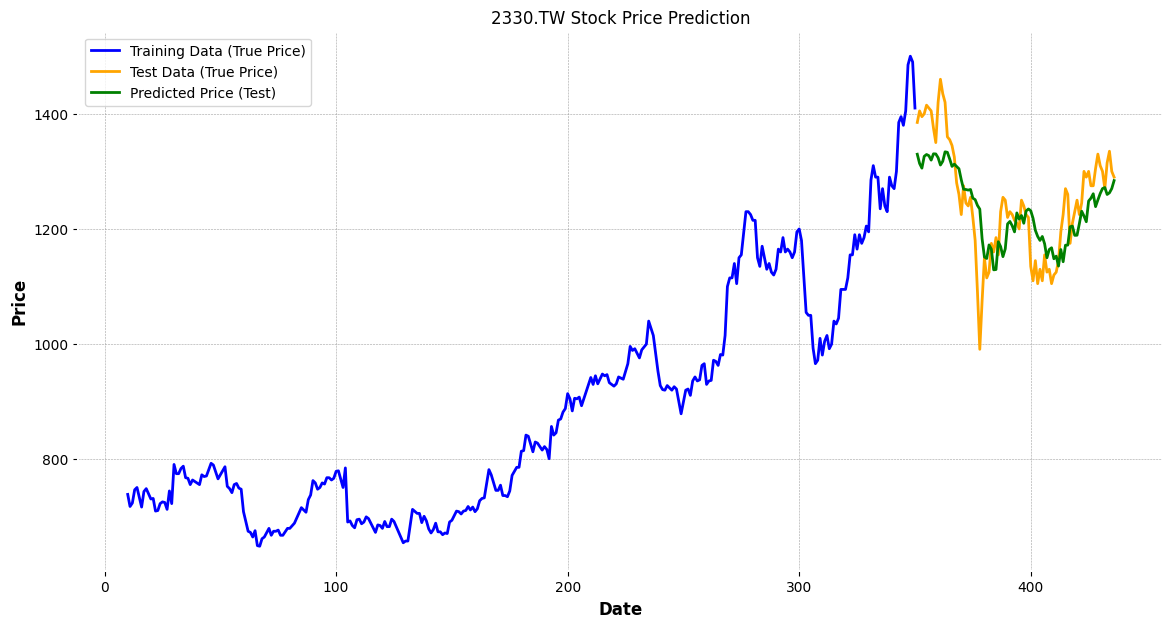

In [24]:
# 繪製結果
plt.figure(figsize=(14, 7))

# 繪製訓練資料的真實價格
plt.plot(range(T, T + len(y_train_actual)), y_train_actual, label='Training Data (True Price)', color='blue')

# 繪製測試資料的真實價格
plt.plot(range(T + len(y_train_actual), T + len(y_train_actual) + len(y_test_actual)), y_test_actual,
         label='Test Data (True Price)', color='orange')

# 繪製預測價格
#plt.plot(range(T, T + len(train_pred)), train_pred, label='Predicted Price (Training)', color='green', alpha=0.7)
plt.plot(range(T + len(y_train_actual), T + len(y_train_actual) + len(test_pred)), test_pred,
         label='Predicted Price (Test)', color='green')

# 圖片標題與標籤
plt.title('2330.TW Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### 作業2

In [1]:
!pip install yfinance matplotlib mplfinance pandas


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import os
import datetime as dt
from sklearn.metrics import mean_squared_error # 計算 mse 誤差

In [3]:
# 抓取 180 天的股票資料，設定股票代碼（例如台積電 2330.TW）
ticker = '2454.TW'  # TW 表示台灣股市
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

'''抓取特定時間'''
# start = dt.datetime(2020, 1, 1)  # 指定的開始日期
# end = dt.datetime(2024, 10, 10)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(ticker, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
stock_data.columns = stock_data.columns.droplevel('Ticker')

# 顯示前幾列資料以確認抓取是否成功
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

Price                        Adj Close   Close    High     Low    Open  \
Date                                                                     
2024-05-03 00:00:00+00:00  1017.493591  1040.0  1050.0  1030.0  1040.0   
2024-05-06 00:00:00+00:00  1012.601807  1035.0  1060.0  1035.0  1060.0   
2024-05-07 00:00:00+00:00  1022.385376  1045.0  1055.0  1035.0  1050.0   
2024-05-08 00:00:00+00:00  1071.303345  1095.0  1100.0  1060.0  1080.0   
2024-05-09 00:00:00+00:00  1071.303345  1095.0  1125.0  1090.0  1100.0   

Price                       Volume  
Date                                
2024-05-03 00:00:00+00:00  6598170  
2024-05-06 00:00:00+00:00  4516638  
2024-05-07 00:00:00+00:00  3178782  
2024-05-08 00:00:00+00:00  9985063  
2024-05-09 00:00:00+00:00  7792270  


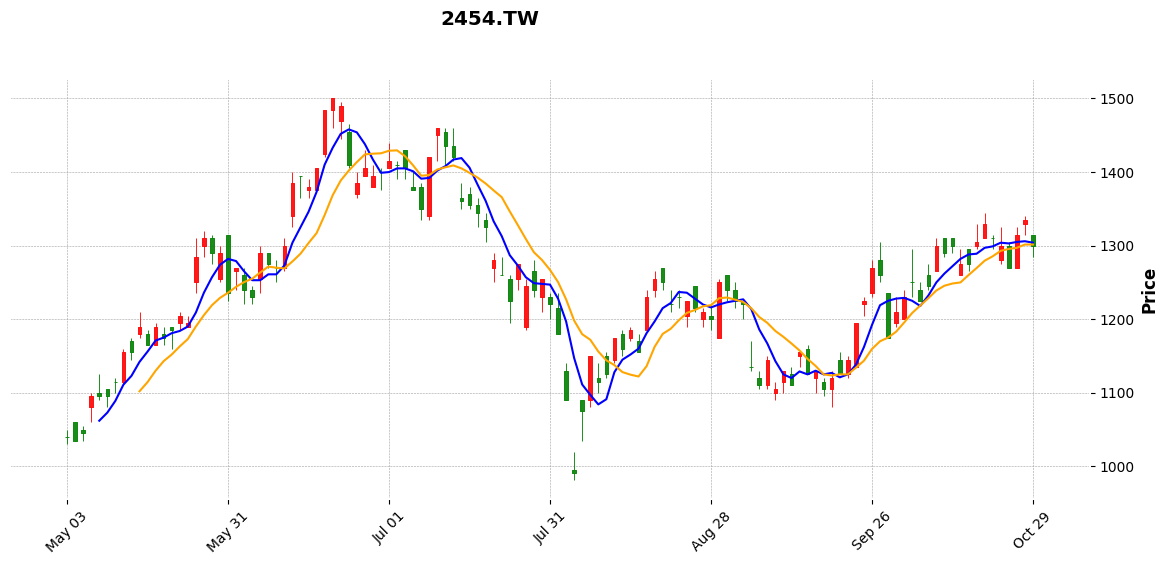

In [4]:
import mplfinance as mpf

# 設置 K 線繪圖風格，漲為紅色，跌為綠色
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='charles', marketcolors=my_color)

# 計算 5 日和 10 日均線
stock_data['MA5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['MA10'] = stock_data['Close'].rolling(window=10).mean()

# 設定兩條均線的顏色
add_plots = [
    mpf.make_addplot(stock_data['MA5'], color='blue', width=1.5),
    mpf.make_addplot(stock_data['MA10'], color='orange', width=1.5)
]

# 繪製 K 線圖並添加均線
mpf.plot(stock_data,
         type='candle',
         style=my_style,
         title=f'{ticker}',
         figsize=(15, 6),
         addplot=add_plots)

# 保存帶有不同顏色均線的 K 線圖
mpf.plot(stock_data,
         type='candle',
         style=my_style,
         title=f'{ticker}',
         figsize=(15, 6),
         addplot=add_plots,
         savefig='k_line_with_colored_ma.png')

In [5]:
# 輸入股票代號
stock_id = '2454.tw'

# 抓取特定時間
start = dt.datetime(2015, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 10, 10)    # 指定的結束日期

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
# 將日期欄位設為索引
stock_data.set_index('Date', inplace=True)
# 刪除 Ticker 欄位並取代
stock_data.columns = stock_data.columns.droplevel('Ticker')
stock_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-05 00:00:00+00:00,279.937042,462.0,467.0,460.0,460.0,2459000
2015-01-06 00:00:00+00:00,277.513306,458.0,462.0,458.0,460.0,5915000
2015-01-07 00:00:00+00:00,294.782135,486.5,487.0,466.5,468.0,13046000
2015-01-08 00:00:00+00:00,293.873260,485.0,494.5,484.5,492.5,8367000
2015-01-09 00:00:00+00:00,295.691040,488.0,495.0,488.0,492.0,7473000
...,...,...,...,...,...,...
2024-10-01 00:00:00+00:00,1210.000000,1210.0,1230.0,1190.0,1195.0,6000269
2024-10-04 00:00:00+00:00,1230.000000,1230.0,1240.0,1200.0,1200.0,6956378
2024-10-07 00:00:00+00:00,1250.000000,1250.0,1295.0,1230.0,1250.0,8959497


In [6]:
from PIL import Image # 處理圖像資料
import random # 隨機
import os # 系統檔，讀取資料使用
import mplfinance as mpf

window_size = 30  # K線圖的時間窗口

# 定義短期和長期均線的週期
short_window = 5  # 短期均線
long_window = 20  # 長期均線

# K線圖保存的文件夹
output_dir = 'k_line_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 儲存標籤
labels = []
file_names = []

# 片利數據並生成標籤和 K 線圖
for i in range(len(stock_data) - window_size):
    window_data = stock_data.iloc[i:i + window_size]  # 當前 K 線圖窗口

    # 計算短期均線和長期均線
    short_ma = window_data['Close'].rolling(window=short_window).mean().iloc[-1]
    long_ma = window_data['Close'].rolling(window=long_window).mean().iloc[-1]

    print(f'窗口{i}的短期均線: {short_ma}, 長期均線: {long_ma}, 標記為', end='')

    # 判斷漲跌：短期均線高於長期均縣則標記為漲，否則標記為跌
    if short_ma > long_ma:
        labels.append(1)  # 漲
        print('「漲」: 1')
    else:
        labels.append(0)  # 跌
        print('「跌」: 0')

    print('\n--------------------------------\n')

    # 生成文件名
    file_name = f'k_line_{i}.png'
    file_names.append(file_name)

    # 保存 K 線圖
    mpf.plot(window_data, type='candle', style=my_style, axisoff=True,
             figsize=(15, 6), savefig=os.path.join(output_dir, file_name))

# 保存標籤到 CSV 文件中
labels_df = pd.DataFrame({
    'file_name': file_names,
    'label': labels
})

labels_df.to_csv('labels.csv', index=False)

串流輸出內容已截斷至最後 5000 行。
窗口1097的短期均線: 319.8, 長期均線: 315.275, 標記為「漲」: 1

--------------------------------

窗口1098的短期均線: 325.8, 長期均線: 317.7, 標記為「漲」: 1

--------------------------------

窗口1099的短期均線: 332.4, 長期均線: 319.825, 標記為「漲」: 1

--------------------------------

窗口1100的短期均線: 337.9, 長期均線: 321.45, 標記為「漲」: 1

--------------------------------

窗口1101的短期均線: 343.6, 長期均線: 323.3, 標記為「漲」: 1

--------------------------------

窗口1102的短期均線: 347.7, 長期均線: 324.775, 標記為「漲」: 1

--------------------------------

窗口1103的短期均線: 345.7, 長期均線: 326.25, 標記為「漲」: 1

--------------------------------

窗口1104的短期均線: 344.6, 長期均線: 327.575, 標記為「漲」: 1

--------------------------------

窗口1105的短期均線: 348.4, 長期均線: 329.6, 標記為「漲」: 1

--------------------------------

窗口1106的短期均線: 352.5, 長期均線: 332.15, 標記為「漲」: 1

--------------------------------

窗口1107的短期均線: 357.5, 長期均線: 334.825, 標記為「漲」: 1

--------------------------------

窗口1108的短期均線: 363.0, 長期均線: 337.55, 標記為「漲」: 1

--------------------------------

窗口1109的短期均線: 366.7, 長期均線: 340

In [7]:
# 顯示漲跌數據筆數
labels_df['label'].value_counts()

,count
label,
1,1258
0,1089


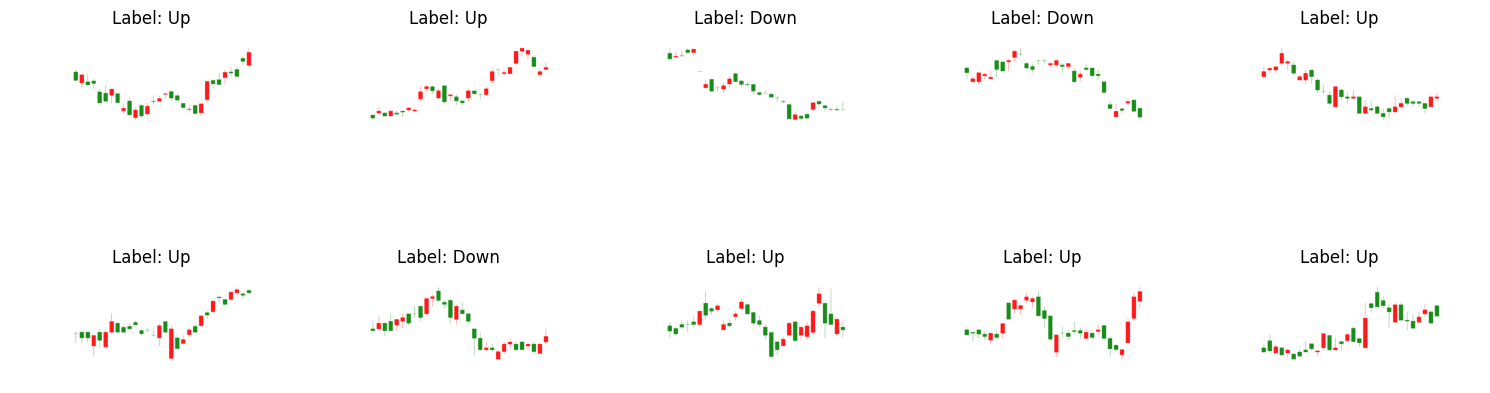

In [8]:
# 載入 CSV label檔案
output_dir = 'k_line_images'
labels_df = pd.read_csv('labels.csv', dtype={'label': str})

# 隨機選10張圖
random_indices = random.sample(range(len(labels_df)), 10)
selected_images = labels_df.iloc[random_indices]

# 設定 2*5 畫布
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# 將圖放進畫布中
for i, (index, row) in enumerate(selected_images.iterrows()):
    img_path = os.path.join(output_dir, row['file_name'])
    img = Image.open(img_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {'Up' if row['label'] == '1' else 'Down'}")

plt.tight_layout()
plt.show()

In [9]:
# 用於資料集拆分訓練、驗證、測試
from sklearn.model_selection import train_test_split

# 先從原始資料中切分出測試集 (20%)
train_df, test_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

# 然後再把訓練集劃分成訓練集與驗證集 (80% 訓練，20% 驗證)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# K線圖位置路徑
image_dir = 'k_line_images/'

# 建立資料集生成器
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,     # 隨機選轉
    width_shift_range=0.1,  # 水平平移
    height_shift_range=0.1, # 垂直平移
    zoom_range=0.1,         # 隨機縮放
    horizontal_flip=True,   # 水平翻轉
    validation_split=0.2)   # 20% 當驗證集

In [11]:
# 訓練集生成器
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary'
)

# 驗證集生成器
validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary'
)

# 測試集生成器（注意這裡不進行資料增強）
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary',
    shuffle=False  # 測試集不需要隨機打亂
)

Found 1501 validated image filenames belonging to 2 classes.
Found 376 validated image filenames belonging to 2 classes.
Found 470 validated image filenames belonging to 2 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # 模型容器
from tensorflow.keras.layers import (
    Input, # 輸入層
    Conv2D,  # 卷積層
    MaxPooling2D, # 最大池化層
    Flatten, # 展平層
    Dense, # 全連接層
    LeakyReLU, # 避免梯度消失
    Dropout, # 避免過擬合
    BatchNormalization # 批次正規化
)
from tensorflow.keras.optimizers import Adam # 模型優化器
from tensorflow.keras.callbacks import ReduceLROnPlateau # 動態調整學習率

# 設定學習率動態調整
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# 建立模型容器
model = Sequential()

model.add(Input(shape=(150, 150, 3)))

# 第一層卷積層 + 批次歸一化 + LeakyReLU + 最大池化
model.add(Conv2D(32, (5, 5)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D((2, 2)))

# 第二層卷積層 + 批次歸一化 + LeakyReLU + 最大池化
model.add(Conv2D(64, (5, 5)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D((2, 2)))

# 第三層卷積層 + 批次歸一化 + LeakyReLU + 最大池化
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D((2, 2)))

# 加入 Dropout 層來防止過擬合
model.add(Dropout(0.2))

# 展平層
model.add(Flatten())

# 全連接層 + LeakyReLU
model.add(Dense(128))
# 加入 Dropout 層
model.add(Dropout(0.2))

model.add(Dense(64))
# 加入 Dropout 層
model.add(Dropout(0.2))

# 輸出層（使用 sigmoid 進行二元分類）
model.add(Dense(1, activation='sigmoid'))

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# 模型訓練
hist = model.fit(
    train_generator,  # 訓練集生成器
    validation_data=validation_generator,  # 驗證集生成器
    epochs=30,  # 訓練週期
    callbacks=[reduce_lr]  # 使用動態調整學習率的回调函數
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 96s 250ms/step - accuracy: 0.5935 - loss: 12.9064 - val_accuracy: 0.4947 - val_loss: 0.7737 - learning_rate: 0.0010
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - accuracy: 0.6554 - loss: 2.9785 - val_accuracy: 0.7340 - val_loss: 0.7158 - learning_rate: 0.0010
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.6511 - loss: 1.7307 - val_accuracy: 0.7500 - val_loss: 0.5578 - learning_rate: 0.0010
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.6647 - loss: 1.0560 - val_accuracy: 0.7819 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 208ms/step - accuracy: 0.6987 - loss: 0.7939 - val_accuracy: 0.5372 - val_loss: 6.1087 - learning_rate: 0.0010
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.7442 - loss: 0.6340 - val_accuracy: 0.4628 - val_loss: 2.9469 - learning_rate: 0.0010
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 207ms/step - accuracy: 0.7507 - loss

In [14]:
# 測試模型
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.8880 - loss: 0.3045
Test accuracy: 0.9042553305625916


In [15]:
# 獲取一批測試集圖片
test_images, test_labels = next(test_generator)
# 預測測試集
predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


實際結果： 漲
預測結果： 漲


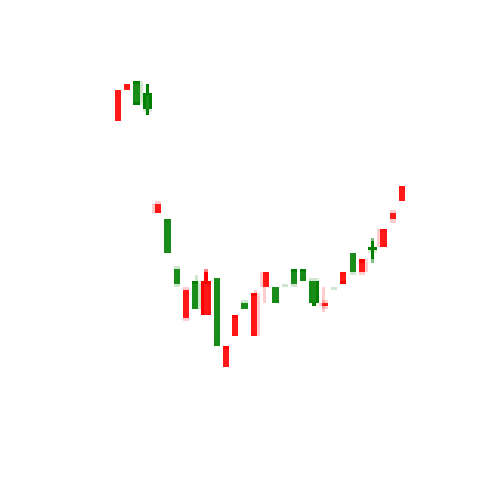

In [16]:
print('實際結果：', '漲' if test_labels[0] == 1 else '跌') # 實際邊謙 0 為跌 1 為漲
print('預測結果：', '漲' if predictions[0] > 0.5 else '跌') # Sigmoid 0.5 為閾值

plt.figure(figsize=(15, 6))
plt.imshow(test_images[0])
plt.axis('off')
plt.show()